In [16]:
import os
import random
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [2]:
# Define a function to sample images randomly from the big folders

def random_sample_files(directory, n_samples, as_array=True):
    """
    Extracts n random samples from the specified directory.

    Input:
    - directory (str): The path to the directory containing the files.
    - n_samples (int): The number of random samples to extract.

    Output:
    - images: an np.array of the output images.
    
    """
    # Get all files in the directory
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Ensure n_samples is not greater than the number of available files
    n_samples = min(n_samples, len(all_files))
    
    # Randomly sample files
    sampled_files = random.sample(all_files, n_samples)

    # Load images
    if as_array:
        images = [np.array(Image.open(f)) for f in sampled_files]
    else:
        images = [Image.open(f) for f in sampled_files]
    
    return np.array(images)

In [3]:
# Define the model

model = Sequential([
    Input(shape=(300, 300, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Extract training data via random sample and train the model

# Sample big folders for model training data
n_to_train = 1000
positives_train = random_sample_files("./data-synthesis/images/positives-small", n_to_train, True)
negatives_train = random_sample_files("./data-synthesis/images/negatives-small", n_to_train, True)

# Train the model
X = np.concatenate([positives_train, negatives_train], axis=0)  
y = np.array([1]*len(positives_train) + [0]*len(negatives_train)) 
y_categorical = to_categorical(y)
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
_ = model.fit(X_train, y_train, batch_size=20, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.8269 - loss: 9.6389 - val_accuracy: 0.9075 - val_loss: 0.2207
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - accuracy: 0.9487 - loss: 0.1521 - val_accuracy: 0.9675 - val_loss: 0.1309
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 382ms/step - accuracy: 0.9832 - loss: 0.0606 - val_accuracy: 0.9650 - val_loss: 0.1231
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 381ms/step - accuracy: 0.9857 - loss: 0.0413 - val_accuracy: 0.9725 - val_loss: 0.1117
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 379ms/step - accuracy: 0.9890 - loss: 0.0308 - val_accuracy: 0.9750 - val_loss: 0.1189
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - accuracy: 0.9952 - loss: 0.0182 - val_accuracy: 0.9650 - val_loss: 0.1456
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 392ms/step - accuracy: 0.9967 - loss: 0.0172 - val_accuracy: 0.9775 - val_loss: 0.1077
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 380ms/step - accuracy: 0.9954 - loss: 0.0111 - val_accu

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
False Negative Rate (FNR): 0.0000
False Positive Rate (FPR): 0.0100
True Positive Rate (TPR): 1.0000
True Negative Rate (TNR): 0.9900


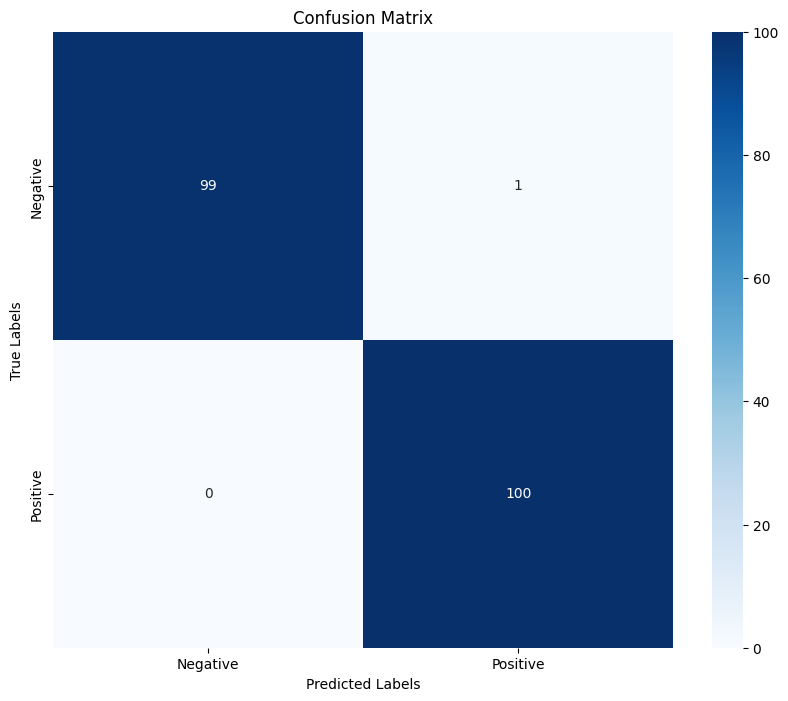

In [13]:
# Predict classes of unseen data with the model
n_to_test = 100
positives = random_sample_files("./data-synthesis/images/positives-small", n_to_test, True)
negatives = random_sample_files("./data-synthesis/images/negatives-small", n_to_test, True)
X_unseen_test = np.concatenate((positives, negatives), axis=0)
y_unseen_test = np.array([1]*n_to_test + [0]*n_to_test)

# Shuffle the dataset
indices = np.arange(X_unseen_test.shape[0])
np.random.shuffle(indices)
X_unseen_test = X_unseen_test[indices]
y_unseen_test = y_unseen_test[indices]

# Make predictions
predictions = model.predict(X_unseen_test)
y_pred = np.argmax(predictions, axis=1)

# Assess model performance
cm = confusion_matrix(y_unseen_test, y_pred)  # Use y_unseen_test and y_pred

# Extracting counts from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculating rates
FNR = FN / (FN+TP)  # False Negative Rate
FPR = FP / (FP+TN)  # False Positive Rate
TPR = TP / (TP+FN)  # True Positive Rate (also known as sensitivity, or recall)
TNR = TN / (TN+FP)  # True Negative Rate (also known as specificity)

# Print the rates
print(f"False Negative Rate (FNR): {FNR:.4f}")
print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


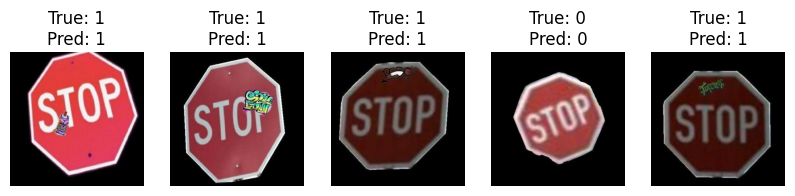

In [17]:


def show_sample_images(X, y_true, y_pred, indices):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(X[idx])
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

# Selecting random indices to display
sample_indices = np.random.choice(X_unseen_test.shape[0], 5, replace=False)

# Displaying the sample images
show_sample_images(X_unseen_test, y_unseen_test, y_pred, sample_indices)

In [18]:
image_from_article = load_img('.data-synthesis/image-from-article.jpg', target_size=(300, 300))

In [27]:
image_from_article_arr = np.array(image_from_article)
image_from_article_arr = np.expand_dims(image_from_article_arr, axis=0) 

model.predict(image_from_article_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0.9952048 , 0.00479517]], dtype=float32)